In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas_profiling as pp
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from textblob import TextBlob
import spacy
from spacy import displacy

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/brianlouie/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel/k

In [100]:
wine = pd.read_csv('data/winemag-data-130k-v2.csv.zip')
wine.head()[:3]

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [101]:
wine = pd.read_csv('data/winemag-data-130k-v2.csv.zip', index_col=0)

#removed index column from the csv file

In [102]:
wine.shape

(129971, 13)

In [103]:
wine.head()[:2]

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos


In [104]:
wine[wine.duplicated(['description','title'])].shape[0]
#9983 descriptions are duplicates

9983

In [105]:
wine = wine.drop_duplicates(['description','title'])
wine.shape

(119988, 13)

In [106]:
wine.isnull().sum().sort_values(ascending=False) / wine.shape[0] * 100

#Percentage of null values in each column

region_2                 61.021936
designation              28.790379
taster_twitter_handle    24.540787
taster_name              20.766243
region_1                 16.301630
price                     6.996533
province                  0.049172
country                   0.049172
variety                   0.000833
winery                    0.000000
title                     0.000000
points                    0.000000
description               0.000000
dtype: float64

In [37]:
wine = wine.dropna(subset=['price'])
wine.info()
wine.isnull().sum().sort_values(ascending=False) / wine.shape[0] * 100

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111593 entries, 1 to 129970
Data columns (total 13 columns):
country                  111538 non-null object
description              111593 non-null object
designation              79533 non-null object
points                   111593 non-null int64
price                    111593 non-null float64
province                 111538 non-null object
region_1                 93580 non-null object
region_2                 46568 non-null object
taster_name              88320 non-null object
taster_twitter_handle    83837 non-null object
title                    111593 non-null object
variety                  111592 non-null object
winery                   111593 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 11.9+ MB


region_2                 58.269784
designation              28.729401
taster_twitter_handle    24.872528
taster_name              20.855251
region_1                 16.141693
province                  0.049286
country                   0.049286
variety                   0.000896
winery                    0.000000
title                     0.000000
price                     0.000000
points                    0.000000
description               0.000000
dtype: float64

In [107]:
no_design = wine[wine.designation.isna()]
no_design[['designation', 'title']][20:30]

#for missing designations looks like Wine type is listed after the year in the title, just before the region

,designation,title
68,NaN,Cocobon 2014 Red (California)
70,NaN,Drumheller 2014 Chardonnay (Columbia Valley (WA))
76,NaN,Schmitt Söhne 2015 Riesling (Rheinhessen)
81,NaN,Spyro 2014 Albariño (Rías Baixas)
86,NaN,Palencia 2016 Albariño (Ancient Lakes)
89,NaN,Fattoria Sardi 2015 Rosato (Toscana)
91,NaN,Folie à Deux 2015 Pinot Gris (Sonoma Coast)
93,NaN,Fuchs 2015 Grüner Veltliner (Burgenland)
95,NaN,Henry Fessy 2015 Juliénas
96,NaN,Henry Fessy 2015 Régnié


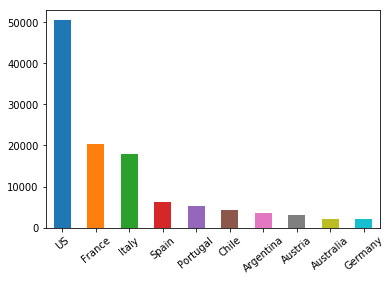

In [10]:
wine['country'].value_counts()[:10].plot(kind='bar',rot=40)
plt.show()

#largest 10 wine producers in this dataset

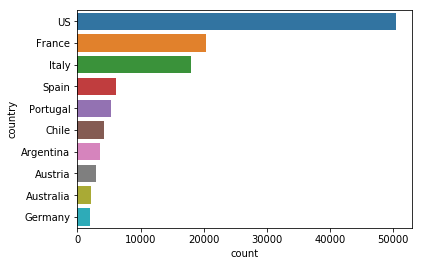

In [109]:
df = wine[wine.country.isin(wine.country.value_counts().head(10).index)]
ax = sns.countplot(y='country', data = df, order= wine['country'].value_counts().head(10).index)
plt.show()

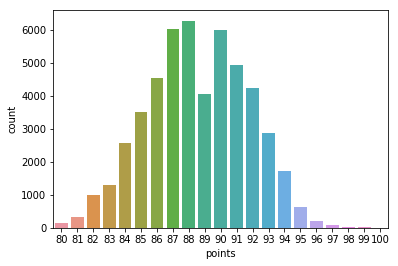

In [110]:
sns.countplot(data = wine[wine['country'] =='US'], x='points')
sns.countplot(data = wine[wine['country'] =='France'], x='points') 
plt.show()

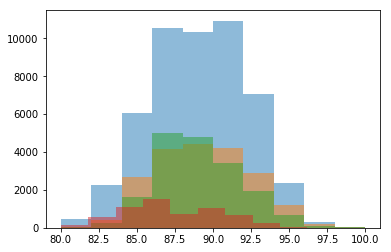

In [89]:
plt.hist(data = wine[wine['country']=='US'], x='points', alpha=0.5)
plt.hist(data = wine[wine['country']=='France'], x='points', alpha=0.5)
plt.hist(data = wine[wine['country']=='Italy'], x='points', alpha=0.5)
plt.hist(data = wine[wine['country']=='Spain'], x='points', alpha=0.5)
plt.show()

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/brianlouie/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 360x360 with 0 Axes>

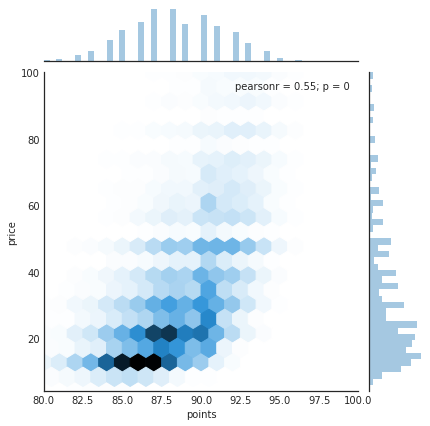

In [87]:
plt.figure(figsize=(5,5))
with sns.axes_style('white'):
    sns.jointplot(x='points', y='price', data= wine[wine['price'] <= 100] , kind='hex', gridsize=20)

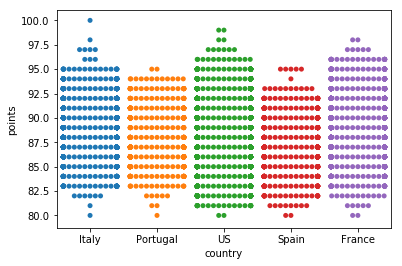

In [53]:
wine_swarm = wine[wine['country'].isin(['US','France','Spain','Italy','Portugal'])][:10000]
sns.swarmplot(x="country", y="points", data=wine_swarm)


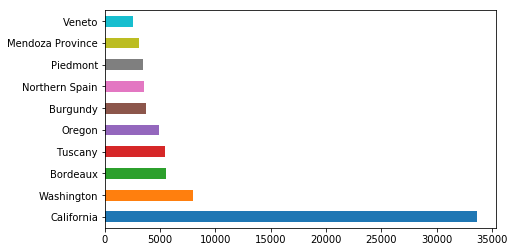

In [54]:
wine['province'].value_counts()[:10].plot(kind='barh',figsize=(7,4))
plt.show()

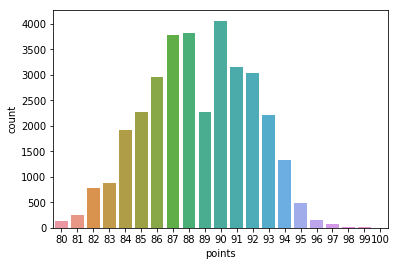

In [81]:
sns.countplot(data = wine[wine['province'] =='California'], x='points')
plt.show()

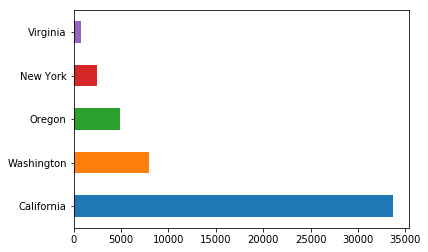

In [56]:
wine[wine['country']=='US']['province'].value_counts()[:5].plot(kind='barh')
plt.show()

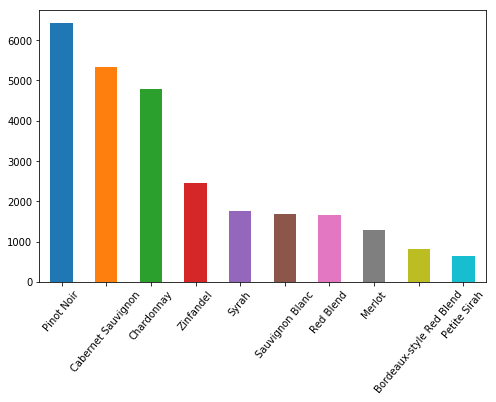

In [57]:
wine[wine['province']=='California']['variety'].value_counts()[:10].plot(kind='bar', figsize = (8,5), rot=50)
plt.show()

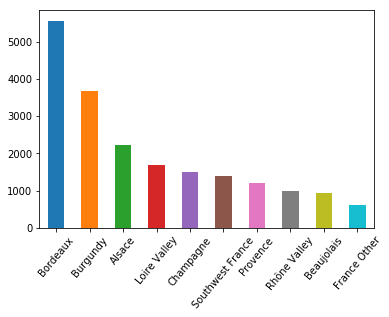

In [90]:
wine[wine['country']=='France']['province'].value_counts()[:10].plot(kind='bar',rot=50)
plt.show()

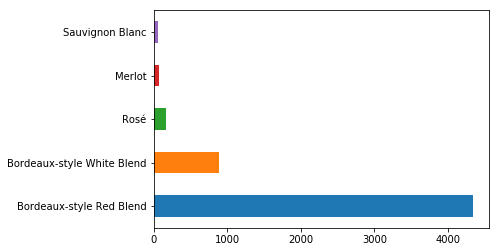

In [91]:
wine[wine['province']=='Bordeaux']['variety'].value_counts()[:5].plot(kind='barh')
plt.show()

In [92]:
wine.variety.value_counts()[:10]

Pinot Noir                  12278
Chardonnay                  10868
Cabernet Sauvignon           8840
Red Blend                    8243
Bordeaux-style Red Blend     6471
Riesling                     4773
Sauvignon Blanc              4575
Syrah                        3828
Rosé                         3220
Merlot                       2896
Name: variety, dtype: int64

In [20]:
wine_variety = wine.variety.unique()
len(wine_variety)

#708 unique wine types 

708

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


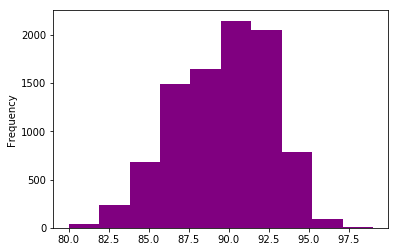

In [93]:
US_pinotnoir = wine[wine['country'] == 'US'][wine['variety']== 'Pinot Noir']
US_pinotnoir['points'].plot(kind='hist', color = 'purple')

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


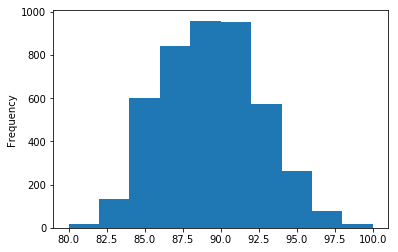

In [94]:
Fra_pinotnoir = wine[wine['country'] == 'France'][wine['variety']== 'Bordeaux-style Red Blend']
Fra_pinotnoir['points'].plot(kind='hist')

In [95]:
ita_pinotnoir = wine[wine['country'] == 'Italy'][wine['variety']== 'Pinot Noir']
esp_pinotnoir = wine[wine['country'] == 'Spain'][wine['variety']== 'Pinot Noir']

/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/brianlouie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Text(0.5,1,'France Pinot Noir Wine Mag rankings')

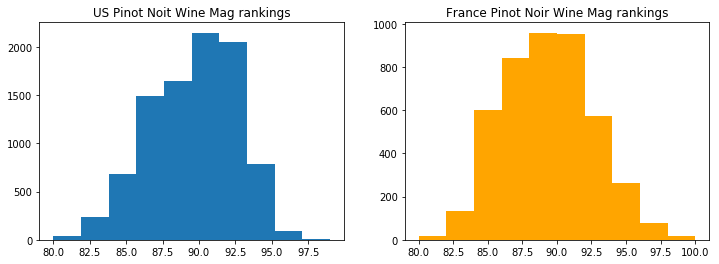

In [96]:
plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.hist(US_pinotnoir['points'])
plt.title('US Pinot Noit Wine Mag rankings')

plt.subplot(1,2,2)
plt.hist(Fra_pinotnoir['points'], color = 'orange')
plt.title('France Pinot Noir Wine Mag rankings')


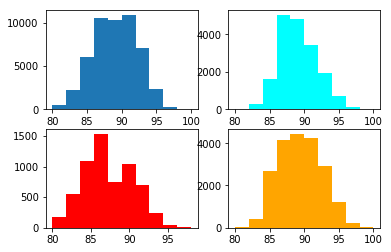

In [97]:
fig, axes = plt.subplots(nrows=2, ncols=2)


plt.subplot(2,2,1)
us_rating = wine[wine['country']== 'US']['points']
plt.hist(us_rating)

plt.subplot(2,2,2)
ita_rating = wine[wine['country']== 'Italy']['points']
plt.hist(ita_rating, color='aqua')

plt.subplot(2,2,3)
esp_rating = wine[wine['country']== 'Spain']['points']
plt.hist(esp_rating, color='red')

plt.subplot(2,2,4)
fra_rating = wine[wine['country']== 'France']['points']
plt.hist(fra_rating, color='orange')

plt.show()

In [111]:
wine.points.describe()

count    119988.000000
mean         88.442236
std           3.092915
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [112]:
wine[wine['points'] > 88.5].shape
#good wines - any wine above median value of ratings

(56737, 13)

In [113]:
wine[wine['points'] < 88.5].shape
#bad wines - in bottom half of ratings

(63251, 13)

In [114]:
tasters = wine['taster_name'].value_counts()
len(tasters)

19

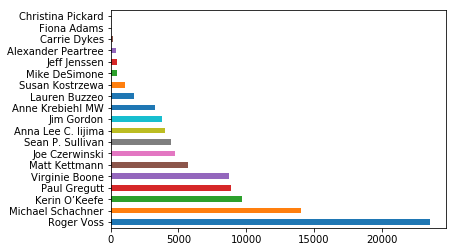

In [115]:
tasters.plot(kind='barh')
plt.show()

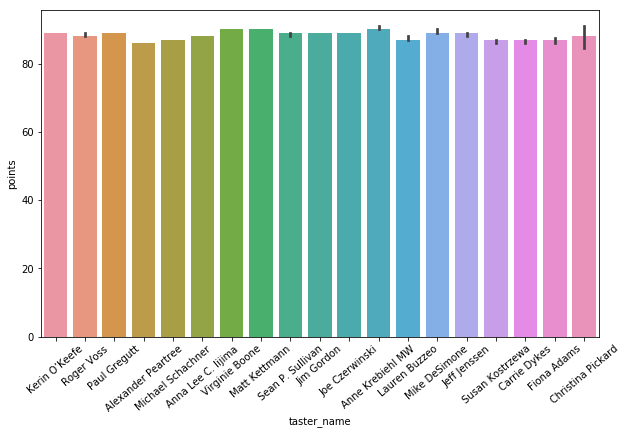

In [37]:
plt.figure(figsize=(10,6))
from numpy import median
ax = sns.barplot(x = 'taster_name', y='points', data=wine , estimator=median)
 
for item in ax.get_xticklabels():
    item.set_rotation(40)

In [38]:
wine.groupby(['taster_name'])['points'].mean()

taster_name
Alexander Peartree    85.780679
Anna Lee C. Iijima    88.416480
Anne Krebiehl MW      90.625228
Carrie Dykes          86.356589
Christina Pickard     87.833333
Fiona Adams           86.750000
Jeff Jenssen          88.330275
Jim Gordon            88.603558
Joe Czerwinski        88.524339
Kerin O’Keefe         88.897803
Lauren Buzzeo         87.692941
Matt Kettmann         90.061431
Michael Schachner     86.857112
Mike DeSimone         89.125813
Paul Gregutt          89.094159
Roger Voss            88.733107
Sean P. Sullivan      88.754988
Susan Kostrzewa       86.575758
Virginie Boone        89.220946
Name: points, dtype: float64

In [116]:
wine['variety'].isnull().value_counts()

False    119987
True          1
Name: variety, dtype: int64

In [117]:
wine['variety'].fillna(value = 'Unknown', inplace=True)

In [118]:
wine['country'].isnull().value_counts()

False    119929
True         59
Name: country, dtype: int64

In [119]:
wine['country'].fillna(value = 'Unknown', inplace=True)
wine['country'].isnull().value_counts()

False    119988
Name: country, dtype: int64

In [122]:
wine = wine.dropna(subset=['price'])

In [123]:
wine.isnull().sum().sort_values(ascending=False)

region_2                 65025
designation              32060
taster_twitter_handle    27756
taster_name              23273
region_1                 18013
province                    55
winery                       0
variety                      0
title                        0
price                        0
points                       0
description                  0
country                      0
dtype: int64

In [124]:
country_variety = wine.groupby(['country','variety'])['variety'].size()
country_variety

country    variety                          
Argentina  Barbera                                 1
           Bonarda                                98
           Bordeaux-style Red Blend               79
           Bordeaux-style White Blend              1
           Cabernet Blend                          8
           Cabernet Franc                         56
           Cabernet Franc-Cabernet Sauvignon       3
           Cabernet Franc-Malbec                   3
           Cabernet Sauvignon                    505
           Cabernet Sauvignon-Cabernet Franc       1
           Cabernet Sauvignon-Malbec              11
           Cabernet Sauvignon-Merlot               5
           Cabernet Sauvignon-Shiraz               3
           Cabernet Sauvignon-Syrah                2
           Cabernet-Malbec                         1
           Cabernet-Syrah                          1
           Champagne Blend                         7
           Chardonnay                            273
 

In [125]:
region_df = wine[(wine['region_1']) != (wine['region_2'])]
region_df.shape[0]

106754

In [126]:
region_df.tail()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,NaN,NaN,Anna Lee C. Iijima,NaN,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,US,Citation is given as much as a decade of bottl...,NaN,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,30.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,Gewürztraminer,Domaine Gresser
129969,France,"A dry style of Pinot Gris, this is crisp with ...",NaN,90,32.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),Pinot Gris,Domaine Marcel Deiss
129970,France,"Big, rich and off-dry, this is powered by inte...",Lieu-dit Harth Cuvée Caroline,90,21.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Domaine Schoffit 2012 Lieu-dit Harth Cuvée Car...,Gewürztraminer,Domaine Schoffit


In [127]:
list(wine.title[30:45])

#looking to pull year of vintage out of the title
#also inside parenthesis is the Region, can use this to fill in NaN values

['Erath 2010 Hyland Pinot Noir (McMinnville)',
 'Estampa 2011 Estate Viognier-Chardonnay (Colchagua Valley)',
 'Feudi del Pisciotto 2010 Missoni Cabernet Sauvignon (Sicilia)',
 'Feudi di San Marzano 2011 I Tratturi Primitivo (Puglia)',
 "Feudo di Santa Tresa 2011 Purato Made With Organic Grapes Nero d'Avola (Sicilia)",
 'Feudo Montoni 2011 Catarratto (Sicilia)',
 'Hawkins Cellars 2009 Pinot Noir (Willamette Valley)',
 'Henry Fessy 2012 Nouveau  (Beaujolais)',
 'Robert Hall 2011 Sauvignon Blanc (Paso Robles)',
 'Sundance 2011 Merlot (Maule Valley)',
 'Tarara 2010 #SocialSecret Red (Virginia)',
 "Tasca d'Almerita 2011 Sallier de la Tour Inzolia (Sicilia)",
 'The White Knight 2011 Riesling (Lake County)',
 'Trump 2011 Sauvignon Blanc (Monticello)',
 'Vignerons de Bel Air 2011 Eté Indien  (Brouilly)']

In [128]:
def name_split(string):
   brian = string.split(sep='(')
   brian1 = brian[-1].split(sep=')')
   return brian1[0]
wine['region'] = wine['title'].map(name_split)
wine.head()

#replaced region_1 and region_2 columns with single region column with 'Region name' pulled fmor title feature

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,region
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Douro
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Willamette Valley
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Lake Michigan Shore
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,Navarra


In [43]:
wine['title'].str.split()[:4]

0               [Nicosia, 2013, Vulkà, Bianco, (Etna)]
1    [Quinta, dos, Avidagos, 2011, Avidagos, Red, (...
2    [Rainstorm, 2013, Pinot, Gris, (Willamette, Va...
3    [St., Julian, 2013, Reserve, Late, Harvest, Ri...
Name: title, dtype: object

In [44]:
[int(s) for s in wine['title'].str.split()[4] if s.isdigit()]

[2012]

In [129]:
wine['title'] = wine['title'].astype(str)

In [130]:
wine['year'] = wine.title.str.extract(r'(\d{4})')

In [131]:
wine['year'].head()

1    2011
2    2013
3    2013
4    2012
5    2011
Name: year, dtype: object

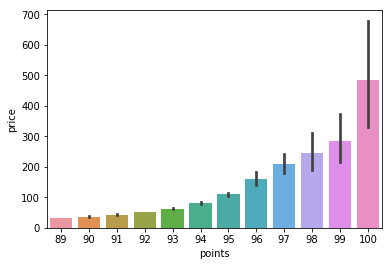

In [132]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']>88.5])

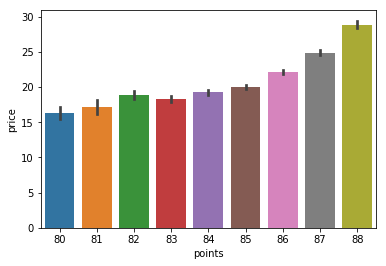

In [133]:
ax = sns.barplot(x="points", y="price", data=wine[wine['points']<88.5])

In [134]:
from datetime import datetime
wine['year'] = pd.to_datetime(wine.year, errors = 'coerce')
wine.info()
wine['year']= wine.year.dt.year

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111593 entries, 1 to 129970
Data columns (total 15 columns):
country                  111593 non-null object
description              111593 non-null object
designation              79533 non-null object
points                   111593 non-null int64
price                    111593 non-null float64
province                 111538 non-null object
region_1                 93580 non-null object
region_2                 46568 non-null object
taster_name              88320 non-null object
taster_twitter_handle    83837 non-null object
title                    111593 non-null object
variety                  111593 non-null object
winery                   111593 non-null object
region                   111593 non-null object
year                     107742 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(12)
memory usage: 13.6+ MB


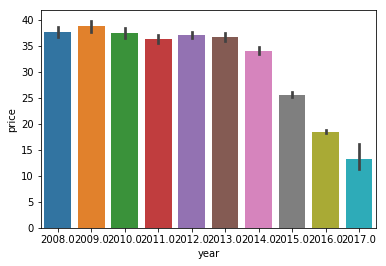

In [135]:
ax = sns.barplot(x="year", y="price", data=wine[wine['year']>2007])

In [136]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,region,year
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Douro,2011.0
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Willamette Valley,2013.0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Lake Michigan Shore,2013.0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley,2012.0
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,Navarra,2011.0


In [137]:
wine['quality'] = wine['points'].map(lambda x: 1 if x>87.5 else 0)
#including quality column to classify wines as good or bad

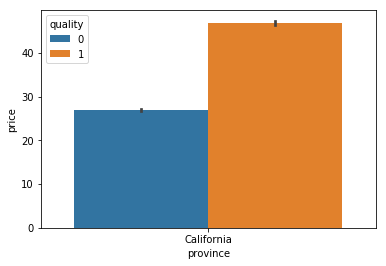

In [141]:
sns.barplot(x = 'province', y='price', hue='quality', data = wine[wine['province']=='California'])

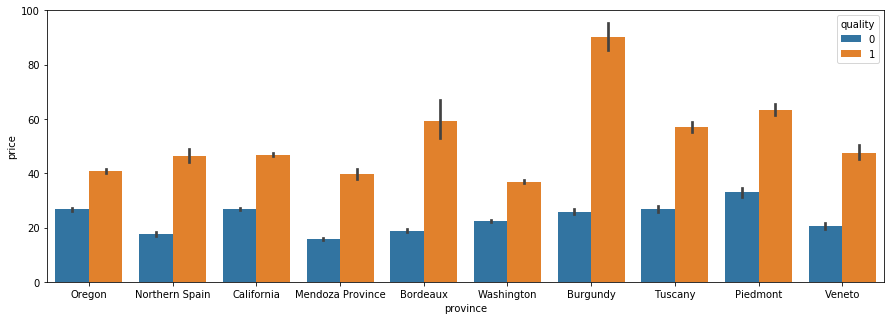

In [179]:
df_province = wine[wine.province.isin(wine.province.value_counts().head(10).index)]

plt.figure(figsize=(15,5))
ax = sns.barplot(x = 'province', y='price', hue='quality', data = df_province)

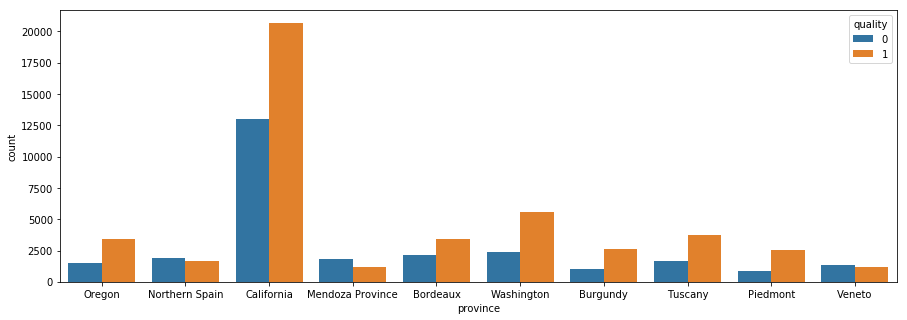

In [182]:
plt.figure(figsize=(15,5))
sns.countplot(x='province', hue='quality', data = df_province)

### Working with NLP and textblob on wine description 

In [113]:
from nltk.tokenize import word_tokenize
import nltk

import re

In [114]:
wine.description[3]

'Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.'

In [115]:
review = wine.description[3]
analysis = TextBlob(review)

In [116]:
analysis.sentiment

Sentiment(polarity=0.16666666666666669, subjectivity=0.3333333333333333)

In [117]:
analysis.words

WordList(['Pineapple', 'rind', 'lemon', 'pith', 'and', 'orange', 'blossom', 'start', 'off', 'the', 'aromas', 'The', 'palate', 'is', 'a', 'bit', 'more', 'opulent', 'with', 'notes', 'of', 'honey-drizzled', 'guava', 'and', 'mango', 'giving', 'way', 'to', 'a', 'slightly', 'astringent', 'semidry', 'finish'])

In [69]:
def polarity_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

In [70]:
def subjectivity_calc(text):
    try:
        return TextBlob(text).sentiment.subjectivity
    except:
        return None

In [71]:
wine['polarity'] = wine['description'].apply(polarity_calc)
wine['subjectivity'] = wine['description'].apply(subjectivity_calc)

In [72]:
wine[['polarity', 'subjectivity']].head()

,polarity,subjectivity
0,0.133333,0.733333
1,0.220000,0.460000
2,0.025000,0.358333
3,0.166667,0.333333
4,0.306667,0.448718


In [73]:
wine[['polarity', 'subjectivity']].describe()

,polarity,subjectivity
count,129971.000000,129971.000000
mean,0.156991,0.496492
std,0.170302,0.151836
min,-0.800000,0.000000
25%,0.042857,0.401886
50%,0.154167,0.500000
75%,0.266667,0.593788
max,1.000000,1.000000


In [118]:
rating = wine.description[8]
rating

"Savory dried thyme notes accent sunnier flavors of preserved peach in this brisk, off-dry wine. It's fruity and fresh, with an elegant, sprightly footprint."

In [119]:
if re.search(r'fruit.',review):
        print("fruity wine")

In [120]:
if re.search(r'fruit.',wine.description[8]):
        print("fruity wine")
    

fruity wine


In [60]:
txt = 'fruit\w+'

In [61]:
re.findall(txt, review)

[]

In [62]:
re.findall(txt, rating)

['fruity']

In [121]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
transformer

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [122]:
vect = TfidfVectorizer(stop_words='english', lowercase = True)

In [124]:
wine_sample = wine.description[:5000]
X= vect.fit_transform(wine_sample)

In [66]:
wineX = X.toarray()

In [67]:
wine_vocab = vect.get_feature_names()
wine_words = pd.DataFrame(wineX, columns = wine_vocab)
wine_words.head()

,000,08,10,100,11,12,13,14,15,150,...,zestiness,zesty,zin,zinfandel,zing,zingy,zins,zippy,zweigelt,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
reg_test = pd.concat([wine.points , wine_words],axis=1)
reg_test.head()

,points,000,08,10,100,11,12,13,14,15,...,zestiness,zesty,zin,zinfandel,zing,zingy,zins,zippy,zweigelt,über
0,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
reg_test.shape

(119988, 538)

In [94]:
reg_test.notnull().sum()[:10]

points       200
15           200
2018         200
2019         200
2020         200
accents      200
acidity      200
almond       200
alongside    200
anise        200
dtype: int64

In [79]:
reg_test = reg_test.dropna()

In [80]:
X = reg_test.drop('points',axis=1)
y = reg_test.points

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [81]:
X.shape

(200, 285)

In [82]:
y.shape

(200,)

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(StandardScaler(), LinearRegression())
degrees = {'polynomialfeatures__degree': [i for i in range(1, 5)]}

grid = GridSearchCV(pipe, param_grid=degrees)

In [84]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1)

In [85]:
ridge_reg.fit(X_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [86]:
rpred = ridge_reg.predict(X_test)

In [87]:
score = ridge_reg.score(X_test, y_test)
print('The r2 value is : {:.4f}'.format(score))

The r2 value is : 0.3551


In [88]:
np.sum(ridge_reg.coef_ != 0)

285

In [90]:
ridge_reg.coef_

array([-0.59366265,  1.30579522,  0.56785089,  0.97467969, -0.11928891,
       -0.33644341, -0.83726472, -0.3496633 ,  0.82882707, -0.18755208,
        0.58139441, -0.62535949, -1.13618579,  0.31723831, -0.69672108,
       -0.2703027 ,  1.75951391,  0.8371717 ,  0.25606639,  0.93536519,
        0.12032811,  0.38818249,  0.06340849,  1.13379535,  0.14117501,
        0.52384297,  0.76313015,  0.49515471, -0.73497864,  0.98356522,
       -0.54592121, -0.67038628,  0.75953713, -0.09626139, -0.98598684,
       -0.47603904, -0.08614658,  0.379667  ,  0.08588055,  0.09950466,
        0.07319833,  0.18496283, -0.47517515, -0.54333053,  0.7527495 ,
       -0.19162583,  0.63289773,  0.57048888,  0.98762488,  0.08062454,
       -0.03675626,  0.87915189, -0.48214598, -0.01257593,  0.27906696,
       -0.32411311,  0.02177154,  0.41892449,  1.15998165,  0.36093613,
        0.55393662,  0.36334034,  0.37106912,  0.31566716, -0.70131144,
       -0.18755717,  1.9279552 ,  0.28318783, -0.81440878,  0.38

In [188]:
#wine_sample = wine_sample.astype(str)


In [125]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('[a-zA-Z]\w+')
from nltk.tokenize import WordPunctTokenizer

In [126]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [153]:
wine_sample = wine.description[:15000]
wine_tokens = [] 
for string in wine_sample:
    wine_tokens.append(tokenizer.tokenize(string))
#tokenizer.tokenize(wine_sample)
#tokens

In [154]:
wine_list = sum(wine_tokens, [])


In [155]:
words = []
for word in wine_list:
    words.append(word.lower())

In [156]:
wine_wordin = [w for w in words if not w in stop_words]
print(wine_wordin[:100])

['aromas', 'include', 'tropical', 'fruit', 'broom', 'brimstone', 'dried', 'herb', 'palate', 'overly', 'expressive', 'offering', 'unripened', 'apple', 'citrus', 'dried', 'sage', 'alongside', 'brisk', 'acidity', 'ripe', 'fruity', 'wine', 'smooth', 'still', 'structured', 'firm', 'tannins', 'filled', 'juicy', 'red', 'berry', 'fruits', 'freshened', 'acidity', 'already', 'drinkable', 'although', 'certainly', 'better', 'tart', 'snappy', 'flavors', 'lime', 'flesh', 'rind', 'dominate', 'green', 'pineapple', 'pokes', 'crisp', 'acidity', 'underscoring', 'flavors', 'wine', 'stainless', 'steel', 'fermented', 'pineapple', 'rind', 'lemon', 'pith', 'orange', 'blossom', 'start', 'aromas', 'palate', 'bit', 'opulent', 'notes', 'honey', 'drizzled', 'guava', 'mango', 'giving', 'way', 'slightly', 'astringent', 'semidry', 'finish', 'much', 'like', 'regular', 'bottling', 'comes', 'across', 'rather', 'rough', 'tannic', 'rustic', 'earthy', 'herbal', 'characteristics', 'nonetheless', 'think', 'pleasantly', 'unfu

In [157]:
wine_text = nltk.Text(wine_wordin)
fdist = nltk.FreqDist(wine_text)
type(fdist)

nltk.probability.FreqDist

In [158]:
fdist.most_common(10)

[('wine', 9200),
 ('flavors', 7269),
 ('fruit', 5687),
 ('aromas', 4659),
 ('palate', 4388),
 ('finish', 4036),
 ('acidity', 4016),
 ('tannins', 3457),
 ('drink', 3423),
 ('black', 3412)]

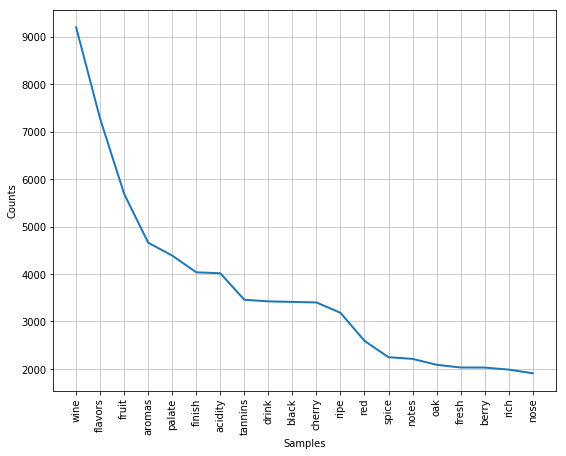

In [159]:
plt.figure(figsize = (9, 7))
fdist.plot(20)

In [79]:
C_vect = CountVectorizer(stop_words='english')
C_vect.fit_transform(wine_sample)
print(C_vect.vocabulary_)

{'aromas': 206, 'include': 1508, 'tropical': 3070, 'fruit': 1264, 'broom': 441, 'brimstone': 425, 'dried': 938, 'herb': 1435, 'palate': 2070, 'isn': 1558, 'overly': 2049, 'expressive': 1092, 'offering': 2009, 'unripened': 3125, 'apple': 189, 'citrus': 607, 'sage': 2521, 'alongside': 158, 'brisk': 432, 'acidity': 101, 'ripe': 2457, 'fruity': 1269, 'wine': 3255, 'smooth': 2707, 'structured': 2852, 'firm': 1170, 'tannins': 2940, 'filled': 1153, 'juicy': 1589, 'red': 2378, 'berry': 317, 'fruits': 1268, 'freshened': 1249, 'drinkable': 941, 'certainly': 542, 'better': 320, '2016': 31, 'tart': 2945, 'snappy': 2711, 'flavors': 1184, 'lime': 1708, 'flesh': 1186, 'rind': 2452, 'dominate': 919, 'green': 1370, 'pineapple': 2156, 'pokes': 2203, 'crisp': 773, 'underscoring': 3109, 'stainless': 2790, 'steel': 2811, 'fermented': 1141, 'lemon': 1675, 'pith': 2167, 'orange': 2033, 'blossom': 355, 'start': 2797, 'bit': 328, 'opulent': 2032, 'notes': 1988, 'honey': 1467, 'drizzled': 948, 'guava': 1392, 'm

In [239]:
wine_dict = C_vect.vocabulary_

In [252]:
df_winewords = pd.DataFrame.from_dict(wine_dict, orient = 'index', columns=['word_count'])
df_winewords.head()

,word_count
aromas,206
include,1508
tropical,3070
fruit,1264
broom,441


In [270]:
df_winewords['word_count'].sort_values(ascending=False)[:20]

über          3316
zweigelt      3315
zippy         3314
zins          3313
zingy         3312
zing          3311
zinfandel     3310
zin           3309
zesty         3308
zestiness     3307
zest          3306
zealand       3305
yum           3304
youthfully    3303
youthful      3302
youth         3301
yountville    3300
young         3299
yogurt        3298
yields        3297
Name: word_count, dtype: int64

In [280]:
sum_words = df_winewords['word_count'].unique().sum()
df_winewords['pct_count'] = df_winewords['word_count'] / sum_words * 100

In [281]:
df_winewords.head()

,word_count,pct_count
aromas,206,0.003746
include,1508,0.027420
tropical,3070,0.055822
fruit,1264,0.022984
broom,441,0.008019


In [282]:
df_winewords['pct_count'].sort_values(ascending=False)[:20]

über          0.060295
zweigelt      0.060277
zippy         0.060259
zins          0.060241
zingy         0.060223
zing          0.060205
zinfandel     0.060186
zin           0.060168
zesty         0.060150
zestiness     0.060132
zest          0.060114
zealand       0.060095
yum           0.060077
youthfully    0.060059
youthful      0.060041
youth         0.060023
yountville    0.060005
young         0.059986
yogurt        0.059968
yields        0.059950
Name: pct_count, dtype: float64

In [183]:
#df_winewords['pct_count'].sort_values(ascending=False)[:20].plot()

In [145]:
cali_top20 = wine[wine['province']=='California']['region'].value_counts()[:20]
cali_top20 = pd.DataFrame(cali_top20)
cali_top20 = cali_top20.reset_index()
cali_top20.columns = ['region_name', 'region_count']
cali_top20

,region_name,region_count
0,Napa Valley,4170
1,Russian River Valley,2861
2,California,2466
3,Paso Robles,2133
4,Sonoma Coast,1368
5,Sonoma County,1162
6,Carneros,930
7,Santa Barbara County,912
8,Sta. Rita Hills,900
9,Dry Creek Valley,867


In [162]:
import geopy
import geopandas
import geocoder
import googlemaps
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [158]:
#cali_top20_locations = geopandas.tools.geocode(cali_top20.region_name, provider = 'google' )
#gmaps.geocode('Santa Maria Valley')

NameError: name 'gmaps' is not defined

In [211]:
df_geo = pd.DataFrame({'name': ['paris', 'berlin', 'london']})
geolocator = Nominatim(user_agent="MyGA_project")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
df_geo['location'] = df_geo['name'].apply(geocode)
df_geo['point'] = df_geo['location'].apply(lambda loc: list(loc.point) if loc else None)
df_geo

,name,location,point
0,paris,"(Paris, Île-de-France, France métropolitaine, ...","[48.85881005, 2.32003101155031, 0.0]"
1,berlin,"(Berlin, 10117, Deutschland, (52.5170365, 13.3...","[52.5170365, 13.3888599, 0.0]"
2,london,"(London, Greater London, England, SW1A 2DU, UK...","[51.5073219, -0.1276474, 0.0]"


In [225]:
cali_top20['location'] = cali_top20['region_name'].apply(geocode)
cali_top20['point'] = cali_top20['location'].apply(lambda loc: list(loc.point) if loc else None)


In [228]:
def long_lat(lst):
    lst.pop(2)
    return lst
    

In [229]:
cali_top20['real_point'] = cali_top20['point'].apply(long_lat)


AttributeError: 'NoneType' object has no attribute 'pop'

In [230]:
cali_top20.head()

,region_name,region_count,location,point,real_point
0,Napa Valley,4170,"(名賢居 Napa Valley, 藍地 Lam Tei, 麒麟圍 Kei Lun Wai,...","[22.41124455, 113.980393164403]",None
1,Russian River Valley,2861,"(Russian River, Mendocino County, California, ...","[38.9028592, -123.0581113]",None
2,California,2466,"(California, United States of America, (36.701...","[36.7014631, -118.7559974]",None
3,Paso Robles,2133,"(Paso Robles, San Luis Obispo County, Californ...","[35.6267654, -120.6912456]",None
4,Sonoma Coast,1368,"(Coast Guard Training Center Petaluma, Two Roc...","[38.2481125, -122.786881081212]",None


In [231]:
import folium

In [233]:
cali_top20.point[1]

[38.9028592, -123.0581113]

In [234]:
m = folium.Map(location= cali_top20.point[1])

In [235]:
m